## IMPORTS

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import nltk
import pyLDAvis.gensim_models
from tqdm import tqdm
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS as stopwords_wordcloud
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.temporal_lda_model import TemporalLdaModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## GLOBALS

In [3]:
corpus_path = ".\\dataverse_files\\UNGDC_1946-2023\\TXT"

In [4]:
# Lista com as pastas para cada ano de conferência

list_pastas = []
for root, dirs, files in os.walk(corpus_path):
    for dir in dirs:
        list_pastas.append(dir)

In [5]:
data = []

# Itera sobre cada pasta (ano de conferência)
for pasta in tqdm(list_pastas, desc = "Processando pastas"):
    pasta_path = os.path.join(corpus_path, pasta)
    
    # Itera sobre cada arquivo de texto na pasta
    for arq in os.listdir(pasta_path):
        # Ignora arquivos ocultos
        if not arq.startswith('.'):
            arq_path = os.path.join(pasta_path, arq)

            # Obtém ano e código do país do nome do arquivo
            ano = pasta.split(' - ')[1]
            codigo_pais = arq.split('_')[0]
            
            # Faz a leitura do conteúdo do arquivo
            with open(arq_path, 'r', encoding = 'utf-8') as f:
                discurso = f.read()
            
            # Adiciona o conteúdo do arquivo à lista de discursos
            data.append([ano, codigo_pais, discurso])

# Cria um dataframe da lista de discursos
df = pd.DataFrame(data, columns = ['ano', 'pais', 'texto'])

list_symbols = [
    '—', '–', '“', '”',
    '’', '‘', '…', ',',
    '.', '!', '?', ';',
    ':', '(', ')', '[',
    ']', '{', '}', '<',
    '>', '/', '\\', '|',
    '@', '#', '$', '%',
    '&', '*', '+', "'s",
    '"', '`', "''", '´',
]

# Remove símbolos da lista de símbolos
for symbol in list_symbols:
    df['texto'] = df['texto'].str.replace(symbol, '')


# df.to_csv('UNGDC_1946-2023.csv', index=False)

print(df)

Processando pastas: 100%|██████████| 78/78 [02:33<00:00,  1.96s/it]


        ano pais                                              texto
0      1946  ARG  At the resumption of the first session of the ...
1      1946  AUS  The General Assembly of the United Nations is ...
2      1946  BEL  The\tprincipal organs of the United Nations ha...
3      1946  BLR  As more than a year has elapsed since the Unit...
4      1946  BOL  Coming to this platform where so many distingu...
...     ...  ...                                                ...
10755  2023  WSM  Samoa extends its congratulations and best wis...
10756  2023  YEM  This session of the General Assembly is being ...
10757  2023  ZAF  Seventy-eight years ago in the aftermath of th...
10758  2023  ZMB  The world today is overcome with the overlappi...
10759  2023  ZWE  I wish to congratulate Mr Dennis Francis on hi...

[10760 rows x 3 columns]


##### REMOVER STOPWORDS

In [6]:
# Elabora um df geral dos discursos mas sem stopwords
stop_words = set(stopwords.words("english"))
df['texto_sem_stopwords'] = df['texto'].apply(
    lambda x: ' '.join([
        word for word in x.split()
        if word.lower() not in stop_words
    ])
)

##### LEMMATIZAÇÃO

In [7]:
# Baixa os recursos necessários do nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
lem = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lem.lemmatize(word) for word in words]

    valid_lem_words = []

    for word in lemmatized_words:
        if len(word) > 2:
            valid_lem_words.append(word)

    return ' '.join(valid_lem_words)

df['texto_lemmatized'] = df['texto_sem_stopwords'].apply(lemmatize_text)

##### SEPARAÇÃO DOS GRUPOS

In [9]:
# Faz a separação dos discursos dos países membros do G7
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
df_g7 = df[df['pais'].isin(G7)]

BRICS = ['BRA', 'RUS', 'IND', 'CHN', 'ZAF']
df_brics = df[df['pais'].isin(BRICS)]

MERCOSUL = [
    'ARG', 'BRA', 'PRY', 'URY'
]
df_mercosul = df[df['pais'].isin(MERCOSUL)]

AU = [
    'ZAF', 'EGY', 'NGA', 'KEN', 'ETH', 'GHA', 'UGA', 'SEN', 'MOZ', 'TAN', 'CIV', 
    'ZMB', 'MLI', 'MWI', 'MWG', 'LSO', 'NAM', 'TGO'
]
df_au = df[df['pais'].isin(AU)]

NATO = [
    'USA', 'CAN', 'GBR', 'DEU', 'FRA', 'ITA', 'JPN', 'NLD', 'ESP', 'POL', 'TUR', 
    'DNK', 'BEL', 'CHE', 'NOR', 'PRT', 'HUN', 'ROU', 'BGR'
]
df_nato = df[df['pais'].isin(NATO)]

EU = [
    'AUT', 'SWE', 'FIN', 'IRL', 'GRC', 'CZE', 'SVK', 'SVN', 'LVA', 'LTU', 'BGR', 
    'CYP', 'EST', 'LUX', 'NLD', 'BEL', 'DEU', 'FRA', 'ITA', 'ESP', 'POL', 'HUN', 
    'ROU', 'SVK', 'GRC', 'POR'
]
df_eu = df[df['pais'].isin(EU)]

In [10]:
df

,ano,pais,texto,texto_sem_stopwords,texto_lemmatized
0,1946,ARG,At the resumption of the first session of the ...,resumption first session General Assembly Arge...,resumption first session General Assembly Arge...
1,1946,AUS,The General Assembly of the United Nations is ...,General Assembly United Nations meeting time h...,General Assembly United Nations meeting time h...
2,1946,BEL,The\tprincipal organs of the United Nations ha...,principal organs United Nations functioning ne...,principal organ United Nations functioning nea...
3,1946,BLR,As more than a year has elapsed since the Unit...,year elapsed since United Nations Charter sign...,year elapsed since United Nations Charter sign...
4,1946,BOL,Coming to this platform where so many distingu...,Coming platform many distinguished eloquent sp...,Coming platform many distinguished eloquent sp...
...,...,...,...,...,...
10755,2023,WSM,Samoa extends its congratulations and best wis...,Samoa extends congratulations best wishes Mr P...,Samoa extends congratulation best wish Preside...
10756,2023,YEM,This session of the General Assembly is being ...,session General Assembly held new extremely co...,session General Assembly held new extremely co...
10757,2023,ZAF,Seventy-eight years ago in the aftermath of th...,Seventy-eight years ago aftermath Second World...,Seventy-eight year ago aftermath Second World ...
10758,2023,ZMB,The world today is overcome with the overlappi...,world today overcome overlapping challenges wa...,world today overcome overlapping challenge war...


## VISÃO GERAL

### Histograma do número de caracteres por discurso

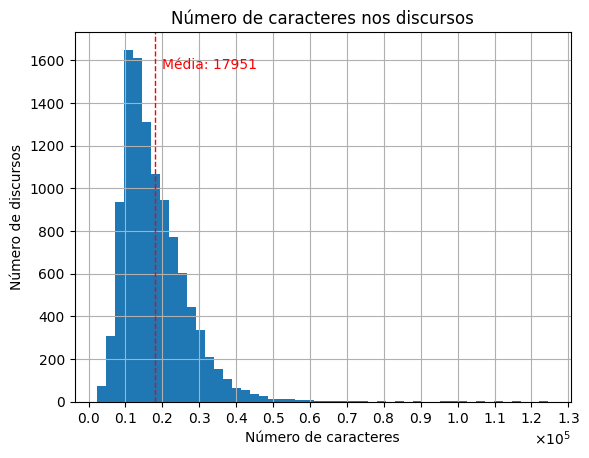

In [10]:
df['n_caracteres_total'] = df['texto'].apply(lambda x: len(x))
df['n_caracteres_total'].hist(bins=50)
plt.xlabel("Número de caracteres")
plt.ylabel("Número de discursos")
plt.title("Número de caracteres nos discursos")

# Adiciona a linha da média
media_caracteres = int(df['n_caracteres_total'].mean())
plt.axvline(media_caracteres, color='r', linestyle = 'dashed', linewidth = 1)
plt.text(media_caracteres + 2000, plt.ylim()[1] * 0.9, f'Média: {media_caracteres}', color = 'r')

# Eixo x em notação científica
plt.ticklabel_format(style = 'scientific', axis = 'x', scilimits = (0,0), useMathText = True)

# Número de ticks no eixo x
plt.locator_params(axis = 'x', nbins = 16)

plt.show()

### Histograma da quantidade de palavras por discurso

MAX: 21899
MIN: 419


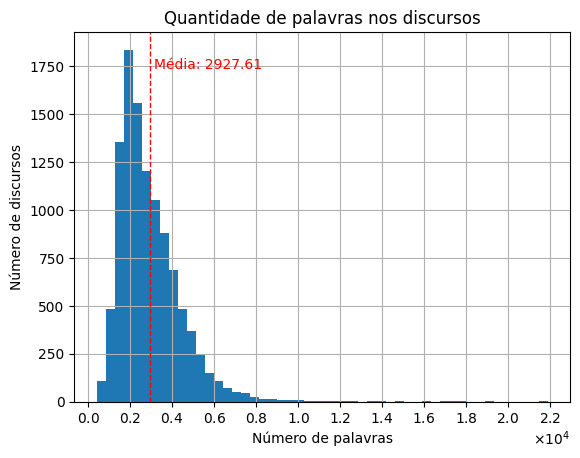

In [11]:
df['n_palavras'] = df['texto'].apply(lambda x: len(x.split()))
df['n_palavras'].hist(bins = 50)
plt.xlabel("Número de palavras")
plt.ylabel("Número de discursos")
plt.title("Quantidade de palavras nos discursos")

# Discurso com mais palavras
print(f"MAX: {df['n_palavras'].max()}")

# Discurso com menos palavras
print(f"MIN: {df['n_palavras'].min()}")

# Adiciona a linha da média
media_palavras = df['n_palavras'].mean()
plt.axvline(media_palavras, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(media_palavras + 200, plt.ylim()[1] * 0.9, f'Média: {media_palavras:.2f}', color = 'r')

# Eixo x em notação científica
plt.ticklabel_format(style = 'scientific', axis = 'x', scilimits = (0,0), useMathText = True)

# Mais ticks no eixo x
plt.locator_params(axis = 'x', nbins = 16)

plt.show()

### Histograma do tamanho médio das palavras por discurso

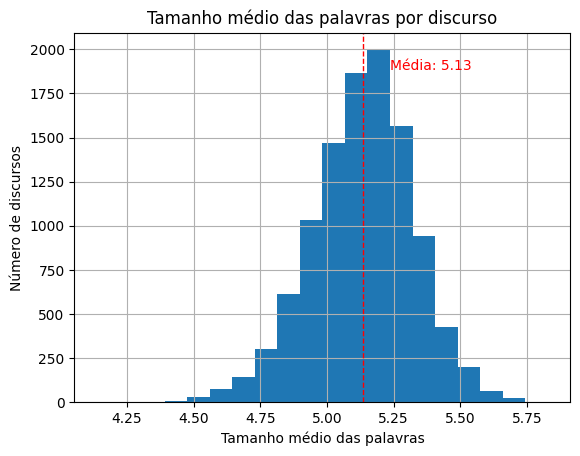

In [12]:
df['tamanho_palavras'] = df['texto'].apply(lambda x: sum(len(p) for p in x.split()) / len(x.split()))
df['tamanho_palavras'].hist(bins = 20)
plt.xlabel("Tamanho médio das palavras")
plt.ylabel("Número de discursos")
plt.title("Tamanho médio das palavras por discurso")

# Adiciona uma linha indicando a média do tamanho das palavras por discurso
media_tamanho_palavras = df['tamanho_palavras'].mean()
plt.axvline(media_tamanho_palavras, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(media_tamanho_palavras + 0.1, plt.ylim()[1] * 0.9, f'Média: {media_tamanho_palavras:.2f}', color = 'r')

plt.show()

### Histograma da quantidade de palavras por tamanho de palavra

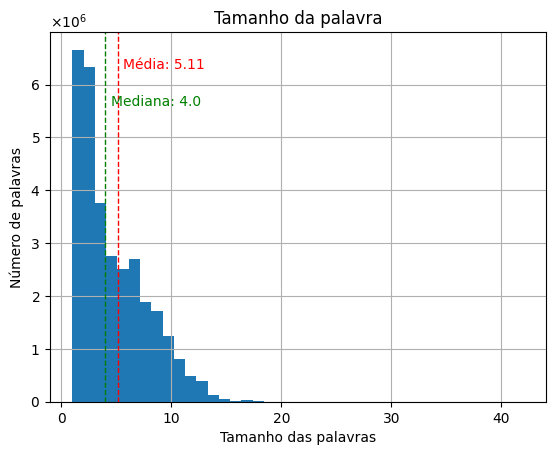

In [13]:
tamanho_palavras = df['texto'].str.split().explode().str.len()
tamanho_palavras.hist(bins = 40)
plt.xlabel("Tamanho das palavras")
plt.ylabel("Número de palavras")
plt.title("Tamanho da palavra")

media_tamanho = tamanho_palavras.mean()
mediana_tamanho = tamanho_palavras.median()
# Linha da média
plt.axvline(media_tamanho, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(media_tamanho + 0.5, plt.ylim()[1] * 0.9, f"Média: {media_tamanho:.2f}", color='r')

# Linha da mediana
plt.axvline(mediana_tamanho, color='g', linestyle='dashed', linewidth=1)
plt.text(mediana_tamanho + 0.5, plt.ylim()[1] * 0.8, f"Mediana: {mediana_tamanho}", color='g')

# Eixo y em notação científica
plt.ticklabel_format(style = 'scientific', axis = 'y', scilimits = (0,0), useMathText = True)

plt.show()

### Histograma com a contagem de stopwords em inglês

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


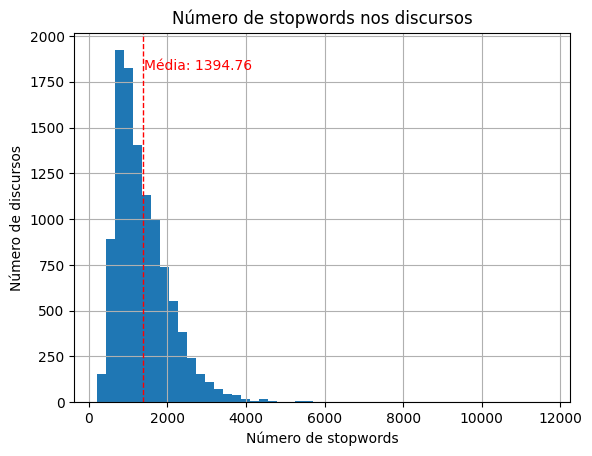

In [14]:
# Utiliza a biblioteca nltk para obter a lista de stopwords em inglês
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

df['n_stopwords'] = df['texto'].apply(lambda x: len([p for p in x.split() if p.lower() in stop_words]))
df['n_stopwords'].hist(bins=50)
plt.xlabel("Número de stopwords")
plt.ylabel("Número de discursos")
plt.title("Número de stopwords nos discursos")

# Adiciona a linha da média
media_stopwords = df['n_stopwords'].mean()
plt.axvline(media_stopwords, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(media_stopwords + 10, plt.ylim()[1] * 0.9, f"Média: {media_stopwords:.2f}", color='r')

plt.show()


### Gráfico de barras da frequência das 15 stopwords mais comuns

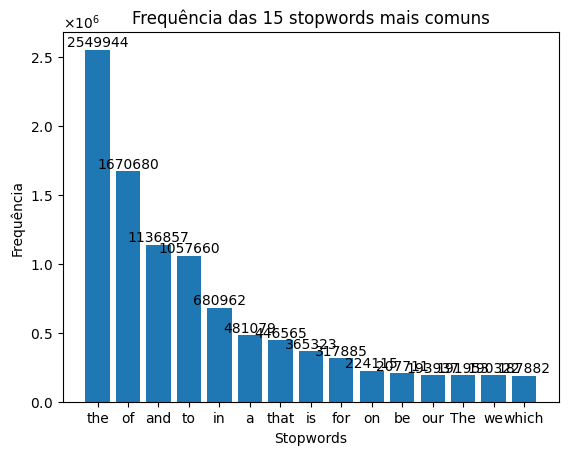

In [15]:
stopwords_freq = Counter([p for p in ' '.join(df['texto']).split() if p.lower() in stop_words])
stopwords_freq = stopwords_freq.most_common(15)

plt.bar([p[0] for p in stopwords_freq], [p[1] for p in stopwords_freq])
plt.xlabel("Stopwords")
plt.ylabel("Frequência")
plt.title("Frequência das 15 stopwords mais comuns")

# Adiciona os valores no topo das barras
for i, freq in enumerate(stopwords_freq):
    plt.text(i, freq[1], freq[1], ha='center', va='bottom')

# Eixo y em notação científica
plt.ticklabel_format(style = 'scientific', axis = 'y', scilimits = (0,0), useMathText = True)

plt.show()

### Gráfico de barras da frequência das 15 palavras mais comuns

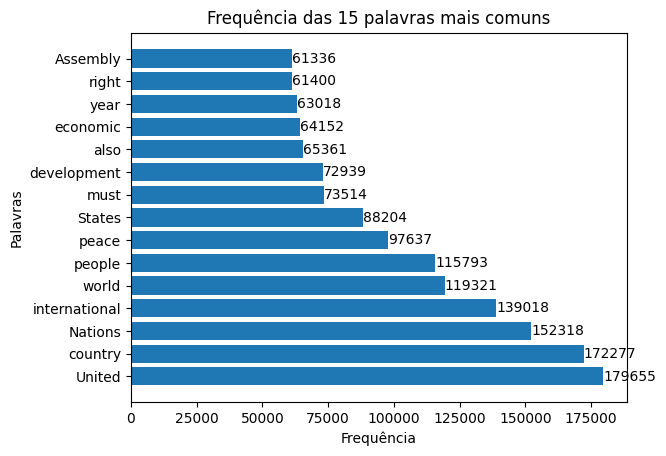

In [16]:
palavras_freq = Counter([p for p in ' '.join(df['texto_lemmatized']).split() if p.lower() not in stop_words])
palavras_freq_mais_comum = palavras_freq.most_common(15)

plt.barh([p[0] for p in palavras_freq_mais_comum], [p[1] for p in palavras_freq_mais_comum])
plt.xlabel("Frequência")
plt.ylabel("Palavras")
plt.title("Frequência das 15 palavras mais comuns")

# Adiciona os valores no final das barras
for i, freq in enumerate(palavras_freq_mais_comum):
    plt.text(freq[1], i, freq[1], ha = 'left', va = 'center')

plt.show()

### Gráfico de barras da frequência das 15 palavras mais comuns excluindo algumas específicas

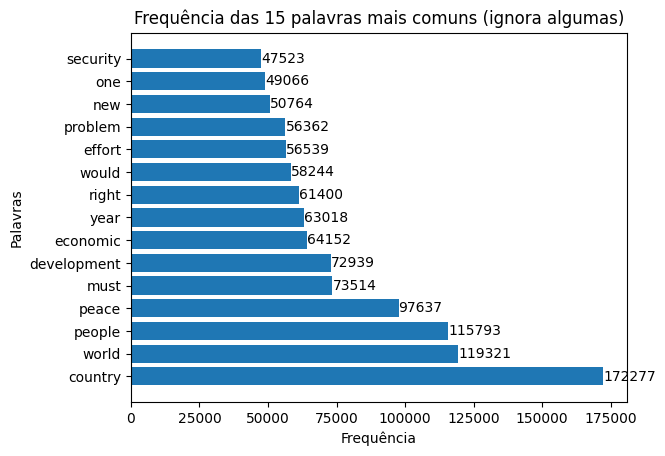

In [17]:
palavras_nao_incluir = [
    'United',
    'Nations',
    'States',
    'Government',
    'international',
    'countries',
    'us',
    'also',
    'Assembly',
    'General',
    '—'
]

palavras_freq_exc_algumas = Counter([p for p in ' '.join(df['texto_lemmatized']).split() if p.lower() not in stop_words and p not in palavras_nao_incluir])
palavras_freq_mais_comum_exc_algumas = palavras_freq_exc_algumas.most_common(15)

plt.barh([p[0] for p in palavras_freq_mais_comum_exc_algumas], [p[1] for p in palavras_freq_mais_comum_exc_algumas])
plt.xlabel("Frequência")
plt.ylabel("Palavras")
plt.title("Frequência das 15 palavras mais comuns (ignora algumas)")

# Adiciona os valores no final das barras
for i, freq in enumerate(palavras_freq_mais_comum_exc_algumas):
    plt.text(freq[1], i, freq[1], ha = 'left', va = 'center')

plt.show()

### Gráfico de barras do número de discursos por país

#### G7

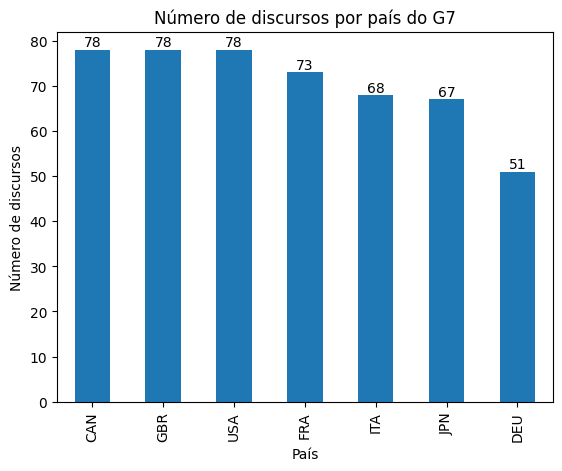

In [18]:
sigla_paises_g7 = ['USA', 'GBR', 'FRA', 'DEU', 'ITA', 'CAN', 'JPN']

df_g7 = df[df['pais'].isin(sigla_paises_g7)]
df_g7['pais'].value_counts().plot(kind = 'bar')
plt.title("Número de discursos por país do G7")

plt.xlabel("País")
plt.ylabel("Número de discursos")

for i, freq in enumerate(df_g7['pais'].value_counts()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')

plt.show()

#### BRICS

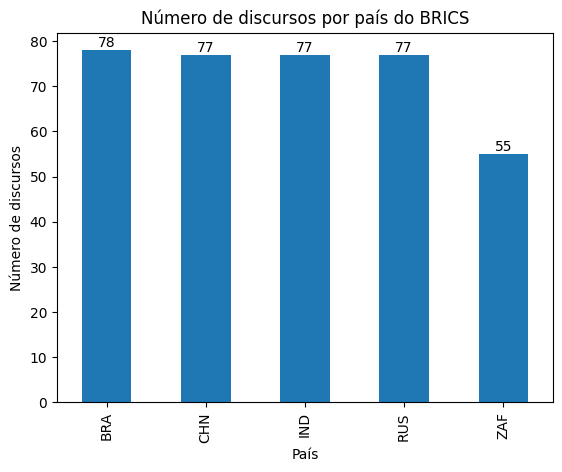

In [19]:
sigla_paises_brics = ['BRA', 'RUS', 'IND', 'CHN', 'ZAF']

df_brics = df[df['pais'].isin(sigla_paises_brics)]
df_brics['pais'].value_counts().plot(kind = 'bar')

plt.title("Número de discursos por país do BRICS")
plt.xlabel("País")
plt.ylabel("Número de discursos")

for i, freq in enumerate(df_brics['pais'].value_counts()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')

plt.show()

#### GRÁFICO MESCLADO

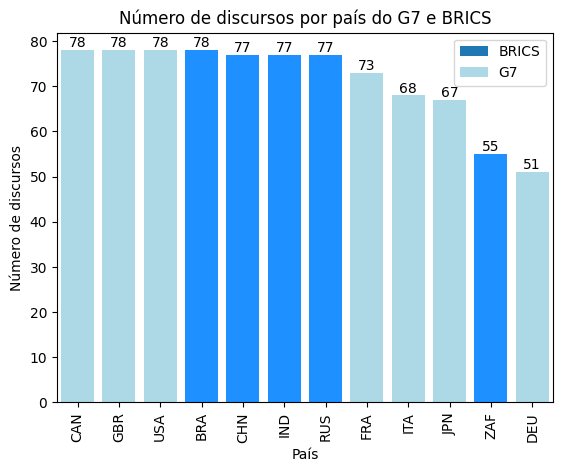

In [20]:
# Gráfico de barras do número de discursos por país do BRICS e G7 ao todo
df_g7_brics = pd.concat([df_g7, df_brics])
df_g7_brics['pais'].value_counts().plot(kind = 'bar')

plt.title("Número de discursos por país do G7 e BRICS")
plt.xlabel("País")
plt.ylabel("Número de discursos")

# Diferencia os países do G7 e BRICS com cores diferentes nas barras e o número de discursos no topo

for i, freq in enumerate(df_g7_brics['pais'].value_counts()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')
    if df_g7_brics['pais'].value_counts().index[i] in sigla_paises_g7:
        plt.bar(i, freq, color = 'lightblue')
    else:
        plt.bar(i, freq, color = 'dodgerblue')

# Legenda para os países do G7 e BRICS de acordo com as cores anteriores
plt.legend(['BRICS', 'G7'])
plt.show()


### Gráfico de barras do número de discursos por ano

#### Período da guerra fria (1946 - 1991)

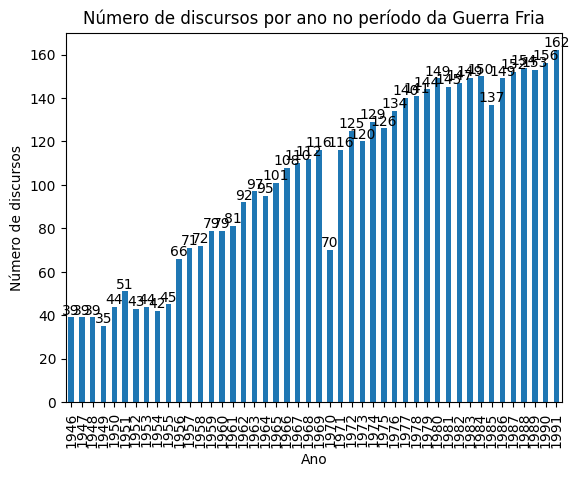

In [21]:
df_guerra_fria = df[df['ano'].between('1946', '1991')]
df_guerra_fria['ano'].value_counts().sort_index().plot(kind = 'bar')
plt.title("Número de discursos por ano no período da Guerra Fria")
plt.xlabel("Ano")
plt.ylabel("Número de discursos")

for i, freq in enumerate(df_guerra_fria['ano'].value_counts().sort_index()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')

plt.show()

#### Período pós-Guerra Fria (1992 - 2023)

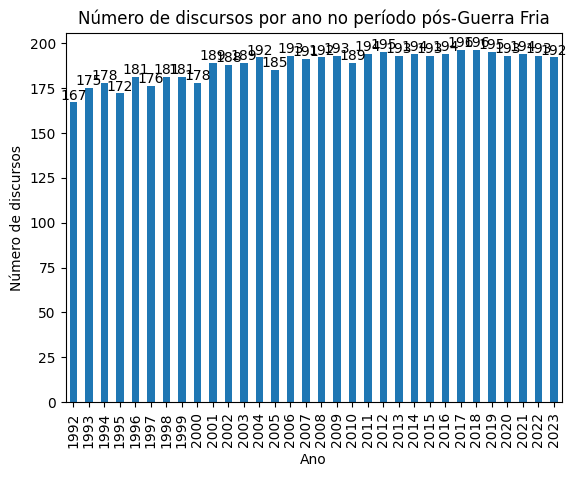

In [22]:
df_pos_guerra_fria = df[df['ano'].between('1992', '2023')]
df_pos_guerra_fria['ano'].value_counts().sort_index().plot(kind = 'bar')

plt.title("Número de discursos por ano no período pós-Guerra Fria")
plt.xlabel("Ano")
plt.ylabel("Número de discursos")

# Adiciona os valores no topo das barras
for i, freq in enumerate(df_pos_guerra_fria['ano'].value_counts().sort_index()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')

plt.show()

## ANÁLISE EXPLORATÓRIA

### EXPLORAÇÃO NGRAM COM STOPWORDS

In [ ]:
def get_top_ngram(corpus, n_top = 10, n = None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [
        (word, sum_words[0, idx])
        for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n_top]

#### GERAL

##### 2GRAM

In [ ]:
top_n_bigrams = get_top_ngram(df['texto'], 25, 2)
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

In [ ]:
top_n_trigrams = get_top_ngram(df['texto'], 25, 3)
x,y=map(list,zip(*top_n_trigrams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

In [ ]:
top_n_5grams = get_top_ngram(df['texto'], 25, 4)
x,y=map(list,zip(*top_n_5grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

In [ ]:
top_n_5grams = get_top_ngram(df['texto'], 25, 5)
x,y=map(list,zip(*top_n_5grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

#### G7

##### 2GRAM

In [ ]:
# Obem os 25 bigramas mais comuns para os países do G7
top_n_bigrams_g7 = get_top_ngram(df_g7['texto'], 25, 2)
x,y=map(list,zip(*top_n_bigrams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

In [ ]:
# Obtem os 25 trigramas mais comuns para os países do G7
top_n_trigrams_g7 = get_top_ngram(df_g7['texto'], 25, 3)
x,y=map(list,zip(*top_n_trigrams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

In [ ]:
# Obtem os 25 quadrigramas mais comuns para os países do G7
top_n_quadrigrams_g7 = get_top_ngram(df_g7['texto'], 25, 4)
x,y=map(list,zip(*top_n_quadrigrams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

In [ ]:
# Os 25 5gramas mais comuns para os países do G7
top_n_5grams_g7 = get_top_ngram(df_g7['texto'], 25, 5)
x,y=map(list,zip(*top_n_5grams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')


#### BRICS

##### 2GRAM

In [ ]:
# Obtem os 25 bigramas mais comuns para os países do BRICS
top_n_2grams_brics = get_top_ngram(df_brics['texto'], 25, 2)
x,y=map(list,zip(*top_n_2grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

In [ ]:
top_n_3grams_brics = get_top_ngram(df_brics['texto'], 25, 2)
x,y=map(list,zip(*top_n_3grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

In [ ]:
top_n_4grams_brics = get_top_ngram(df_brics['texto'], 25, 2)
x,y=map(list,zip(*top_n_4grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

In [ ]:
top_n_5grams_brics = get_top_ngram(df_brics['texto'], 25, 2)
x,y=map(list,zip(*top_n_5grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

### EXPLORAÇÃO NGRAM SEM STOPWORDS

#### GERAL

##### 2GRAM

In [ ]:
# Obtem os 25 2gramas mais comuns do geral sem stopwords
top_n_2grams = get_top_ngram(df['texto_sem_stopwords'], 25, 2)
x,y=map(list,zip(*top_n_2grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

In [ ]:
# Obtem os 25 3gramas mais comuns do geral sem stopwords
top_n_3grams = get_top_ngram(df['texto_sem_stopwords'], 25, 3)
x,y=map(list,zip(*top_n_3grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

In [ ]:
# Obtem os 25 4gramas mais comuns do geral sem stopwords
top_n_4grams = get_top_ngram(df['texto_sem_stopwords'], 25, 4)
x,y=map(list,zip(*top_n_4grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

In [ ]:
# Obtem os 25 5gramas mais comuns do geral sem stopwords
top_n_5grams = get_top_ngram(df['texto_sem_stopwords'], 25, 5)
x,y=map(list,zip(*top_n_5grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

#### G7

##### 2GRAM

In [ ]:
# Obtem os 25 2gramas mais comuns para os países do G7 sem stopwords
top_n_2grams_g7 = get_top_ngram(df_g7['texto_sem_stopwords'], 25, 2)
x,y=map(list,zip(*top_n_2grams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

In [ ]:
# Obtem os 25 3gramas mais comuns para os países do G7 sem stopwords
top_n_3grams_g7 = get_top_ngram(df_g7['texto_sem_stopwords'], 25, 3)
x,y=map(list,zip(*top_n_3grams_g7))
sns.barplot(x=y,y=x)    

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

In [ ]:
# Obtem os 25 4gramas mais comuns para os países do G7 sem stopwords
top_n_4grams_g7 = get_top_ngram(df_g7['texto_sem_stopwords'], 25, 4)
x,y=map(list,zip(*top_n_4grams_g7))
sns.barplot(x=y,y=x)    

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

In [ ]:
# Obtem os 25 5gramas mais comuns para os países do G7 sem stopwords
top_n_5grams_g7 = get_top_ngram(df_g7['texto_sem_stopwords'], 25, 5)
x,y=map(list,zip(*top_n_5grams_g7))
plt.title("Top 25 5-grams mais comuns para os países do G7 sem stopwords")
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

#### BRICS

##### 2GRAM

In [ ]:
# Obtem os 25 2gramas mais comuns para os países do BRICS sem stopwords
top_n_2grams_brics = get_top_ngram(df_brics['texto_sem_stopwords'], 25, 2)
x,y=map(list,zip(*top_n_2grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

In [ ]:
# Obtem os 25 3gramas mais comuns para os países do BRICS sem stopwords
top_n_3grams_brics = get_top_ngram(df_brics['texto_sem_stopwords'], 25, 3)
x,y=map(list,zip(*top_n_3grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

In [ ]:
# Obtem os 25 4gramas mais comuns para os países do BRICS sem stopwords
top_n_4grams_brics = get_top_ngram(df_brics['texto_sem_stopwords'], 25, 4)
x,y=map(list,zip(*top_n_4grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

In [ ]:
# Obtem os 25 5gramas mais comuns para os países do BRICS sem stopwords
top_n_5grams_brics = get_top_ngram(df_brics['texto_sem_stopwords'], 25, 5)
x,y=map(list,zip(*top_n_5grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

### TOPIC MODELING COM pyLDAvis

#### GERAL

##### BAG OF WORDS E LDA MODEL

In [ ]:
dic=gensim.corpora.Dictionary(df['texto_lemmatized'].apply(lambda x: x.split()))
bow_corpus = [dic.doc2bow(doc) for doc in df['texto_lemmatized'].apply(lambda x: x.split())]

lda_model = gensim.models.LdaMulticore(
    bow_corpus,
    num_topics = 10,
    id2word = dic,
    passes = 10,
    workers = 12
)
lda_model.show_topics()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

#### G7

In [ ]:
dic=gensim.corpora.Dictionary(df_g7['texto_lemmatized'].apply(lambda x: x.split()))
bow_corpus = [dic.doc2bow(doc) for doc in df_g7['texto_lemmatized'].apply(lambda x: x.split())]

lda_model = gensim.models.LdaMulticore(
    bow_corpus,
    num_topics = 10,
    id2word = dic,
    passes = 10,
    workers = 12
)
lda_model.show_topics()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

#### BRICS

##### LDA MODEL

In [ ]:
dic=gensim.corpora.Dictionary(df_brics['texto_lemmatized'].apply(lambda x: x.split()))
bow_corpus = [dic.doc2bow(doc) for doc in df_brics['texto_lemmatized'].apply(lambda x: x.split())]

lda_model = gensim.models.LdaMulticore(
    bow_corpus,
    num_topics = 10,
    id2word = dic,
    passes = 10,
    workers = 12
)
lda_model.show_topics()

##### VISUALIZAÇÃO TOPIC MODELING	LDA

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

### TOPIC MODELING COM LDA OVERTIME

#### GERAL

##### MÉDIA

In [29]:
mpl.rc('font', family = 'Arial')

In [23]:
model_ldaot_geral = TemporalLdaModel(
    corpus = df['texto_lemmatized'],
    dates = df["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 5,
    aggregator = "average"
)
main_ldaot_geral = LdaOverTime(model_ldaot_geral)

c:\Programacao\Repositorios\processamento-linguagem-natural\discursos-onu\.venv\Lib\site-packages\lda_over_time\models\temporal_lda_model.py:438: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  [pd.Grouper(key='date', freq=self.freq)],
c:\Programacao\Repositorios\processamento-linguagem-natural\discursos-onu\.venv\Lib\site-packages\lda_over_time\models\temporal_lda_model.py:215: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='date', freq=freq),


In [51]:
for topic_id in range(1, 6):
    print(
        main_ldaot_geral.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=100                # we want the top 10 words for each topic
        )
    )

['country', 'United', 'international', 'Nations', 'people', 'development', 'world', 'peace', 'also', 'must', 'global', 'support', 'effort', 'States', 'year', 'security', 'economic', 'community', 'need', 'right', 'challenge', 'Assembly', 'climate', 'Government', 'human', 'change', 'would', 'commitment', 'President', 'conflict', 'crisis', 'General', 'new', 'Council', 'one', 'continue', 'action', 'time', 'national', 'work', 'region', 'political', 'Development', 'call', 'session', 'Africa', 'African', 'order', 'cooperation', 'developing', 'nation', 'like', 'sustainable', 'Security', 'pandemic', 'issue', 'many', 'future', 'process', 'social', 'Republic', 'Organization', 'system', 'solution', 'take', 'made', 'hope', 'State', 'resource', 'life', 'well', 'including', 'ensure', 'opportunity', 'economy', 'situation', 'reform', 'per', 'progress', 'resolution', 'regard', 'therefore', 'respect', 'principle', 'make', 'poverty', 'address', 'law', 'part', 'towards', 'financial', 'way', 'cent', 'import

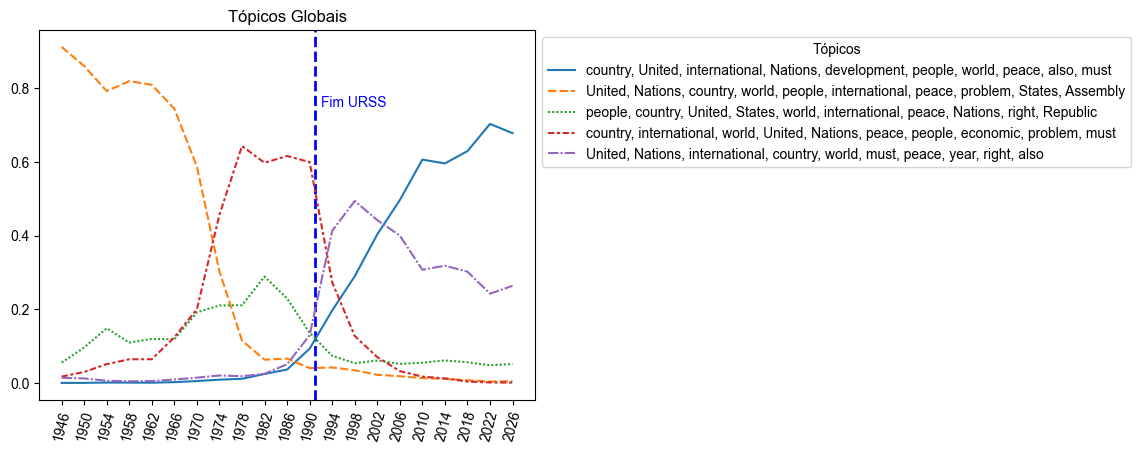

In [31]:
# Adiciona uma linha que demarca o ano do fim da união soviética
plt.axvline(11.25, color='b', linestyle='dashed', linewidth=2)
plt.text(11.5, plt.ylim()[1] * 0.75, "Fim URSS", color='b')

main_ldaot_geral.plot(
    title = 'Tópicos Globais',    # Plot's title
    legend_title="Tópicos",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)


In [ ]:
main_ldaot_geral.n_timeslices

In [ ]:
graph = main_ldaot_geral.showvis(1)
graph

In [ ]:
graph = main_ldaot_geral.showvis(11)
graph

##### PROPORÇÃO

In [ ]:
model_ldaot_geral_prop = TemporalLdaModel(
    corpus = df['texto_lemmatized'],
    dates = df["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 8,
    aggregator = "main"
)
main_ldaot_geral_prop = LdaOverTime(model_ldaot_geral_prop)

In [ ]:
for topic_id in range(1, 9):
    print(
        main_ldaot_geral_prop.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

In [ ]:
main_ldaot_geral_prop.plot(
    title = 'Tópicos Globais',    # Plot's title
    legend_title="Tópicos",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

#### G7

In [32]:
model_lda_g7 = TemporalLdaModel(
    corpus = df_g7['texto_lemmatized'],
    dates = df_g7["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 5,
    aggregator = "average"
)
main_ldaot_g7 = LdaOverTime(model_lda_g7)

c:\Programacao\Repositorios\processamento-linguagem-natural\discursos-onu\.venv\Lib\site-packages\lda_over_time\models\temporal_lda_model.py:438: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  [pd.Grouper(key='date', freq=self.freq)],
c:\Programacao\Repositorios\processamento-linguagem-natural\discursos-onu\.venv\Lib\site-packages\lda_over_time\models\temporal_lda_model.py:215: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='date', freq=freq),


In [34]:
for topic_id in range(1, 6):
    print(
        main_ldaot_g7.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=100                # we want the top 10 words for each topic
        )
    )

['Japan', 'United', 'Nations', 'international', 'country', 'effort', 'peace', 'world', 'year', 'development', 'also', 'community', 'issue', 'Council', 'must', 'nuclear', 'assistance', 'States', 'reform', 'Security', 'human', 'support', 'new', 'people', 'would', 'continue', 'like', 'time', 'cooperation', 'Assembly', 'important', 'General', 'conflict', 'order', 'security', 'weapon', 'global', 'including', 'role', 'area', 'economic', 'resolution', 'take', 'towards', 'make', 'Member', 'session', 'future', 'work', 'challenge', 'region', 'Africa', 'problem', 'contribution', 'developing', 'hope', 'activity', 'need', 'disarmament', 'one', 'Korea', 'importance', 'well', 'situation', 'first', 'made', 'end', 'strengthen', 'stability', 'right', 'Development', 'Conference', 'financial', 'International', 'next', 'Japanese', 'operation', 'nation', 'regard', 'change', 'action', 'Japans', 'African', 'contribute', 'actively', 'measure', 'organization', 'member', 'Government', 'Organization', 'achieve', 

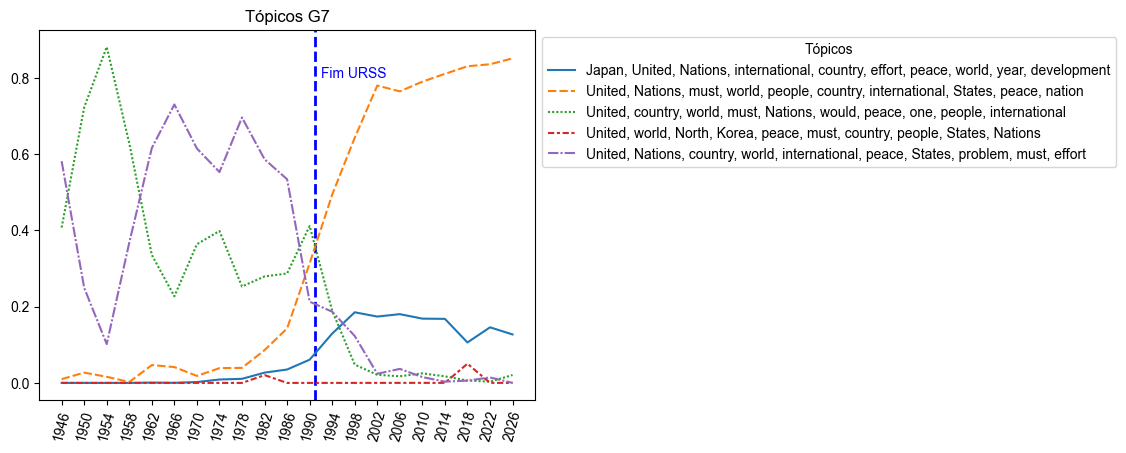

In [33]:
# Adiciona uma linha que demarca o ano do fim da união soviética
plt.axvline(11.25, color='b', linestyle='dashed', linewidth=2)
plt.text(11.5, plt.ylim()[1] * 0.8, "Fim URSS", color='b')

main_ldaot_g7.plot(
    title = 'Tópicos G7',    # Plot's title
    legend_title="Tópicos",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

##### EUA

In [ ]:
model_lda_usa = TemporalLdaModel(
    corpus = df_g7.loc[df_g7['pais'] == 'USA']['texto_lemmatized'],
    dates = df_g7.loc[df_g7['pais'] == 'USA']["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 5,
    aggregator = "average"
)
main_ldaot_usa = LdaOverTime(model_lda_usa)

for topic_id in range(1, 6):
    print(
        main_ldaot_usa.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

# Adiciona uma linha que demarca o ano do fim da união soviética
plt.axvline(11.25, color='b', linestyle='dashed', linewidth=2)
plt.text(8, plt.ylim()[1] * 0.9, "Fim URSS", color='b')

# Adiciona uma linha indicando o ano do ataque às torres gêmeas
plt.axvline(13.75, color='r', linestyle='dashed', linewidth=2)
plt.text(14, plt.ylim()[1] * 1, "Atentado 11 set.", color='r')

main_ldaot_usa.plot(
    title = 'Tópicos EUA',    # Plot's title
    legend_title="10 Palavras mais Frequentes por Tópico",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

#### BRICS

##### GROUPING BY 4 YEARS

In [34]:
model_lda_brics = TemporalLdaModel(
    corpus = df_brics['texto_lemmatized'],
    dates = df_brics["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 5,
    aggregator = "average"
)
main_ldaot_brics = LdaOverTime(model_lda_brics)

c:\Programacao\Repositorios\processamento-linguagem-natural\discursos-onu\.venv\Lib\site-packages\lda_over_time\models\temporal_lda_model.py:438: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  [pd.Grouper(key='date', freq=self.freq)],
c:\Programacao\Repositorios\processamento-linguagem-natural\discursos-onu\.venv\Lib\site-packages\lda_over_time\models\temporal_lda_model.py:215: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='date', freq=freq),


In [36]:
for topic_id in range(1, 6):
    print(
        main_ldaot_brics.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=100                # we want the top 10 words for each topic
        )
    )

['United', 'Nations', 'Africa', 'world', 'South', 'international', 'country', 'people', 'year', 'development', 'peace', 'States', 'Council', 'Assembly', 'also', 'Security', 'General', 'African', 'must', 'right', 'effort', 'global', 'support', 'China', 'would', 'human', 'continue', 'one', 'order', 'issue', 'reform', 'challenge', 'Government', 'cooperation', 'new', 'security', 'work', 'need', 'court', 'role', 'Charter', 'session', 'military', 'President', 'freedom', 'made', 'political', 'community', 'Development', 'nuclear', 'conflict', 'economic', 'Union', 'weapon', 'region', 'Organization', 'towards', 'time', 'Russia', 'life', 'Syria', 'progress', 'interest', 'take', 'great', 'ensure', 'continent', 'nation', 'resolution', 'make', 'stability', 'change', 'action', 'respect', 'Africas', 'war', 'problem', 'common', 'agreement', 'today', 'developing', 'important', 'part', 'question', 'force', 'member', 'process', 'many', 'struggle', 'well', 'responsibility', 'principle', 'threat', 'initiati

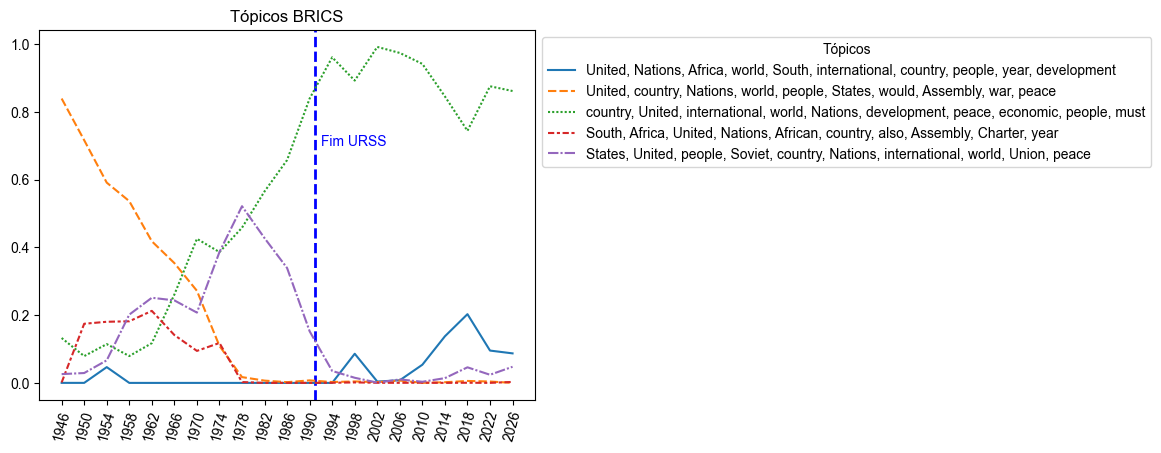

In [35]:
# Adiciona uma linha que demarca o ano do fim da união soviética
plt.axvline(11.25, color='b', linestyle='dashed', linewidth=2)
plt.text(11.5, plt.ylim()[1] * 0.7, "Fim URSS", color='b')


main_ldaot_brics.plot(
    title = 'Tópicos BRICS',    # Plot's title
    legend_title="Tópicos",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

##### GROUPING BY 10 YEARS

In [ ]:
model_lda_brics = TemporalLdaModel(
    corpus = df_brics['texto_lemmatized'],
    dates = df_brics["ano"].values,
    date_format = "%Y",
    freq = "10Y",
    n_topics = 8,
    aggregator = "average"
)
main_ldaot_brics = LdaOverTime(model_lda_brics)

In [ ]:
for topic_id in range(1, 9):
    print(
        main_ldaot_brics.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

In [ ]:
main_ldaot_brics.plot(
    title = 'BRICS Subjects Found 10Y',    # Plot's title
    legend_title="Subjects",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

##### BRAZIL

['Brazil', 'indigenous', 'Brazilian', 'country', 'per', 'cent', 'world', 'people', 'United', 'freedom']
['United', 'Nations', 'international', 'country', 'world', 'peace', 'Brazil', 'economic', 'Assembly', 'would']
['country', 'Brazil', 'world', 'international', 'United', 'Nations', 'must', 'economic', 'peace', 'development']


c:\Programacao\Repositorios\processamento-linguagem-natural\discursos-onu\.venv\Lib\site-packages\lda_over_time\models\temporal_lda_model.py:438: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  [pd.Grouper(key='date', freq=self.freq)],
c:\Programacao\Repositorios\processamento-linguagem-natural\discursos-onu\.venv\Lib\site-packages\lda_over_time\models\temporal_lda_model.py:215: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.Grouper(key='date', freq=freq),


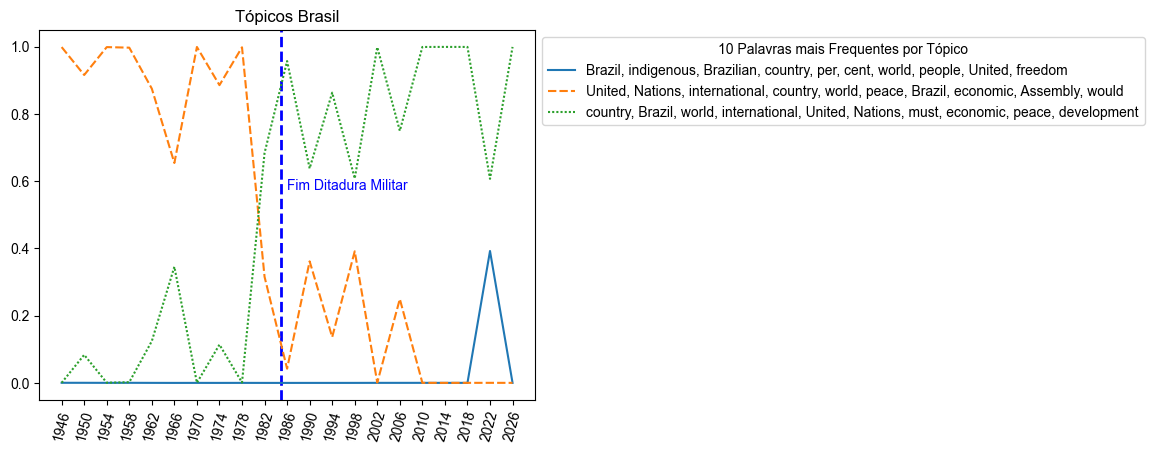

In [93]:
model_lda_bra = TemporalLdaModel(
    corpus = df_brics.loc[df_brics['pais'] == 'BRA']['texto_lemmatized'],
    dates = df_brics.loc[df_brics['pais'] == 'BRA']["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 3,
    aggregator = "average"
)
main_ldaot_bra = LdaOverTime(model_lda_bra)

for topic_id in range(1, 4):
    print(
        main_ldaot_bra.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

# cria uma linha que demarca o ano do fim da ditadura militar
plt.axvline(9.75, color='b', linestyle='dashed', linewidth=2)
plt.text(10, plt.ylim()[1] * 0.575, "Fim Ditadura Militar", color='b')

main_ldaot_bra.plot(
    title = 'Tópicos Brasil',    # Plot's title
    legend_title="10 Palavras mais Frequentes por Tópico",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

##### RUSSIA

In [ ]:
model_lda_rus = TemporalLdaModel(
    corpus = df_brics.loc[df_brics['pais'] == 'RUS']['texto_lemmatized'],
    dates = df_brics.loc[df_brics['pais'] == 'RUS']["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 4,
    aggregator = "average"
)
main_ldaot_rus = LdaOverTime(model_lda_rus)

for topic_id in range(1, 5):
    print(
        main_ldaot_rus.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

# Adiciona uma linha que demarca o ano do fim da união soviética
plt.axvline(11.25, color='b', linestyle='dashed', linewidth=2)
plt.text(11.5, plt.ylim()[1] * 0.9, "Fim URSS", color='b')


main_ldaot_rus.plot(
    title = 'Tópicos Rússia',    # Plot's title
    legend_title="10 Palavras mais Frequentes por Tópico",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

##### CHINA

In [ ]:
model_lda_chn = TemporalLdaModel(
    corpus = df_brics.loc[df_brics['pais'] == 'CHN']['texto_lemmatized'],
    dates = df_brics.loc[df_brics['pais'] == 'CHN']["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 4,
    aggregator = "average"
)
main_ldaot_chn = LdaOverTime(model_lda_chn)

for topic_id in range(1, 5):
    print(
        main_ldaot_chn.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

# Adiciona uma linha no ano de 1975 indicando o fim da guerra com o vietnã
plt.axvline(7.25, color='b', linestyle='dashed', linewidth=2)
plt.text(7.5, plt.ylim()[1] * 0.9, "Fim da Guerra do Vietnã", color='b')

main_ldaot_chn.plot(
    title = 'Tópicos China',    # Plot's title
    legend_title="10 Palavras mais Frequentes por Tópico",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

#### MERCOSUL

In [ ]:
model_lda_mercosul = TemporalLdaModel(
    corpus = df_mercosul['texto_lemmatized'],
    dates = df_mercosul["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 8,
    aggregator = "average"
)
main_ldaot_mercosul = LdaOverTime(model_lda_mercosul)

In [ ]:
for topic_id in range(1, 9):
    print(
        main_ldaot_mercosul.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

In [ ]:
main_ldaot_mercosul.plot(
    title = 'Mercosul Subjects Found 4Y',    # Plot's title
    legend_title="Subjects",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

#### UNIAO EUROPEIA

In [ ]:
model_lda_eu = TemporalLdaModel(
    corpus = df_eu['texto_lemmatized'],
    dates = df_eu["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 8,
    aggregator = "average"
)
main_ldaot_eu = LdaOverTime(model_lda_eu)

In [ ]:
for topic_id in range(1, 9):
    print(
        main_ldaot_eu.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

In [ ]:
main_ldaot_eu.plot(
    title = 'EU Subjects Found 4Y',    # Plot's title
    legend_title="Subjects",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

#### NATO

In [ ]:
model_lda_nato = TemporalLdaModel(
    corpus = df_nato['texto_lemmatized'],
    dates = df_nato["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 8,
    aggregator = "average"
)
main_ldaot_nato = LdaOverTime(model_lda_nato)

In [ ]:
for topic_id in range(1, 9):
    print(
        main_ldaot_nato.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

In [ ]:
main_ldaot_nato.plot(
    title = 'NATO Subjects Found 4Y',    # Plot's title
    legend_title="Subjects",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

#### AU

In [ ]:
model_lda_au = TemporalLdaModel(
    corpus = df_au['texto_lemmatized'],
    dates = df_au["ano"].values,
    date_format = "%Y",
    freq = "4Y",
    n_topics = 8,
    aggregator = "average"
)
main_ldaot_au = LdaOverTime(model_lda_au)

In [ ]:
for topic_id in range(1, 9):
    print(
        main_ldaot_au.get_topic_words(
            topic_id=topic_id,  # select which topic we want
            timeslice=1,        # get the oldest time slice found in our trainning
            n=10                # we want the top 10 words for each topic
        )
    )

In [ ]:
main_ldaot_au.plot(
    title = 'AU Subjects Found 4Y',    # Plot's title
    legend_title="Subjects",     # Legend's title
    # path_to_save="./plot_of_news.png",   # Set location to save
    display=True,                # Display graph (default)
    rotation=75,                 # Rotate labels in 75º
    mode="line",                 # Plot lines (default)
    date_format="%Y",            # Set custom date format to YYYY
)

### CONTAGEM PALAVRAS POR ANO

In [ ]:
# Plota o gráfico do número de países com discursos ao longo dos anos
df['pais'].nunique()
df['ano'].value_counts().sort_index().plot(kind = 'line')
plt.title("Número de países com discursos por ano")
plt.xlabel("Ano")
plt.ylabel("Número de países")
plt.show()

#### GERAL

##### NÃO FILTRADO

In [ ]:
# Obtem as 10 palavras mais comuns de todos os discursos pela lista palavras_freq
top_10_palavras = palavras_freq.most_common(10)

# Calcula a ocorrência das palavras de top_10_palavras por ano ao longo de todos os anos
top_10_palavras_por_ano = {}

for palavra, _ in top_10_palavras:
    top_10_palavras_por_ano[palavra] = df['texto_lemmatized'].apply(lambda x: palavra in x).groupby(df['ano']).sum()

# Cria um DataFrame com as ocorrências das palavras de top_10_palavras por ano
df_top_10_palavras_por_ano = pd.DataFrame(top_10_palavras_por_ano)

# Plota a ocorrência das palavras de top_10_palavras por ano
df_top_10_palavras_por_ano.plot(kind = 'line')
plt.title("Ocorrência das 10 palavras mais comuns por ano")
plt.xlabel("Ano")
plt.ylabel("Ocorrência")
plt.show()

##### FILTRADO

In [ ]:
# Obtem as 10 palavras mais comuns de todos os discursos pela lista palavras_freq
top_10_palavras = palavras_freq_exc_algumas.most_common(10)

# Calcula a ocorrência das palavras de top_10_palavras por ano ao longo de todos os anos
top_10_palavras_por_ano = {}

for palavra, _ in top_10_palavras:
    top_10_palavras_por_ano[palavra] = df['texto_lemmatized'].apply(lambda x: palavra in x).groupby(df['ano']).sum()

# Cria um DataFrame com as ocorrências das palavras de top_10_palavras por ano
df_top_10_palavras_por_ano = pd.DataFrame(top_10_palavras_por_ano)

# Plota a ocorrência das palavras de top_10_palavras por ano
df_top_10_palavras_por_ano.plot(kind = 'line')
plt.title("Ocorrência das 10 palavras mais comuns por ano")
plt.xlabel("Ano")
plt.ylabel("Ocorrência")
plt.show()

#### G7

##### NÃO FILTRADO

In [ ]:
top_10_palavras_g7 = Counter([p for p in ' '.join(df_g7['texto_lemmatized']).split()]).most_common(10)

top_10_palavras_g7_por_ano = {}

for palavra, _ in top_10_palavras_g7:
    top_10_palavras_g7_por_ano[palavra] = df_g7['texto_lemmatized'].apply(lambda x: palavra in x).groupby(df_g7['ano']).sum()

df_top_10_palavras_g7_por_ano = pd.DataFrame(top_10_palavras_g7_por_ano)

df_top_10_palavras_g7_por_ano.plot(kind = 'line')
plt.title("Ocorrência das 10 palavras mais comuns por ano para os países do G7")
plt.xlabel("Ano")
plt.ylabel("Ocorrência")
plt.show()

##### FILTRADO

In [ ]:
top_10_palavras_g7 = Counter([p for p in ' '.join(df_g7['texto_lemmatized']).split() if p not in palavras_nao_incluir]).most_common(10)

top_10_palavras_g7_por_ano = {}

for palavra, _ in top_10_palavras_g7:
    top_10_palavras_g7_por_ano[palavra] = df_g7['texto_lemmatized'].apply(lambda x: palavra in x).groupby(df_g7['ano']).sum()

df_top_10_palavras_g7_por_ano = pd.DataFrame(top_10_palavras_g7_por_ano)

df_top_10_palavras_g7_por_ano.plot(kind = 'line')
plt.title("Ocorrência das 10 palavras mais comuns por ano para os países do G7")
plt.xlabel("Ano")
plt.ylabel("Ocorrência")
plt.show()


#### BRICS

##### NÃO FILTRADO

In [ ]:
top_10_palavras_brics = Counter([p for p in ' '.join(df_brics['texto_lemmatized']).split()]).most_common(10)

top_10_palavras_brics_por_ano = {}

for palavra, _ in top_10_palavras_brics:
    top_10_palavras_brics_por_ano[palavra] = df_brics['texto_lemmatized'].apply(lambda x: palavra in x).groupby(df_brics['ano']).sum()

df_top_10_palavras_brics_por_ano = pd.DataFrame(top_10_palavras_brics_por_ano)

df_top_10_palavras_brics_por_ano.plot(kind = 'line')
plt.title("Ocorrência das 10 palavras mais comuns por ano para os países do BRICS")
plt.xlabel("Ano")
plt.ylabel("Ocorrência")
plt.show()

##### FILTRADO

In [ ]:
top_10_palavras_brics = Counter([p for p in ' '.join(df_brics['texto_lemmatized']).split() if p not in palavras_nao_incluir]).most_common(10)

top_10_palavras_brics_por_ano = {}

for palavra, _ in top_10_palavras_brics:
    top_10_palavras_brics_por_ano[palavra] = df_brics['texto_lemmatized'].apply(lambda x: palavra in x).groupby(df_brics['ano']).sum()

df_top_10_palavras_brics_por_ano = pd.DataFrame(top_10_palavras_brics_por_ano)

df_top_10_palavras_brics_por_ano.plot(kind = 'line')
plt.title("Ocorrência das 10 palavras mais comuns por ano para os países do BRICS")
plt.xlabel("Ano")
plt.ylabel("Ocorrência")
plt.show()

#### MERCOSUL

##### NÃO FILTRADO

In [ ]:
top_10_palavras_mercosul = Counter([p for p in ' '.join(df_mercosul['texto_lemmatized']).split()]).most_common(10)

top_10_palavras_mercosul_por_ano = {}

for palavra, _ in top_10_palavras_mercosul:
    top_10_palavras_mercosul_por_ano[palavra] = df_mercosul['texto_lemmatized'].apply(lambda x: palavra in x).groupby(df_mercosul['ano']).sum()

df_top_10_palavras_mercosul_por_ano = pd.DataFrame(top_10_palavras_mercosul_por_ano)

df_top_10_palavras_mercosul_por_ano.plot(kind = 'line')
plt.title("Ocorrência das 10 palavras mais comuns por ano para os países do Mercosul")
plt.xlabel("Ano")
plt.ylabel("Ocorrência")
plt.show()

##### FILTRADO

In [ ]:
top_10_palavras_mercosul = Counter([p for p in ' '.join(df_mercosul['texto_lemmatized']).split() if p not in palavras_nao_incluir]).most_common(10)

top_10_palavras_mercosul_por_ano = {}

for palavra, _ in top_10_palavras_mercosul:
    top_10_palavras_mercosul_por_ano[palavra] = df_mercosul['texto_lemmatized'].apply(lambda x: palavra in x).groupby(df_mercosul['ano']).sum()

df_top_10_palavras_mercosul_por_ano = pd.DataFrame(top_10_palavras_mercosul_por_ano)

df_top_10_palavras_mercosul_por_ano.plot(kind = 'line')
plt.title("Ocorrência das 10 palavras mais comuns por ano para os países do Mercosul")
plt.xlabel("Ano")
plt.ylabel("Ocorrência")
plt.show()

### NUVEM DE PALAVRAS

#### GERAL

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords_wordcloud,
    max_words=100,
    max_font_size=30,
    scale=3,
    random_state=1)

wordcloud = wordcloud.generate(str(df['texto_lemmatized'].str.cat(sep=' ')))

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()

## PROJETO

### SIMILARIDADE DO COSSENO

In [13]:
def plotar_similaridade_cosseno_ao_longo_dos_anos(PAISES, descricao):
    # Dicionário para armazenar a similaridade do cosseno por país e ano
    similaridade_cosseno = {pais: {} for pais in PAISES}

    df_filtrado = df[df['pais'].isin(PAISES)]

    # Iterar sobre cada ano de 1946 a 2022
    for ano in range(1946, 2023):
        # Filtrar os discursos do ano atual
        discursos_ano = df_filtrado[df_filtrado['ano'].astype(int) == ano]

        # Verificar se há discursos para o ano atual
        if not discursos_ano.empty:
            # Transformar os textos em vetores TF-IDF
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform(
                discursos_ano['texto_lemmatized']
            )

            # Calcular a similaridade do cosseno entre os discursos
            cos_sim = cosine_similarity(tfidf_matrix)

            # Armazenar a média da similaridade do cosseno para cada país
            for i, pais in enumerate(discursos_ano['pais']):
                similaridade_cosseno[pais][ano] = np.mean(cos_sim[i])

    # Converter o dicionário em um DataFrame
    df_similaridade_cosseno = pd.DataFrame(similaridade_cosseno)

    # Plotar a similaridade do cosseno ao longo dos anos
    plt.figure(figsize=(12, 6))
    for pais in PAISES:
        plt.plot(df_similaridade_cosseno.index, df_similaridade_cosseno[pais], label=pais)

    # indica no gráfico o ano de maior média de similaridade do cosseno considerando todos os países
    ano_maior_similaridade = df_similaridade_cosseno.mean(axis=1).idxmax()

    # Obtém a média da similaridade do cosseno para o ano de maior similaridade	
    maior_similaridade = df_similaridade_cosseno.mean(axis=1).max()

    plt.axvline(ano_maior_similaridade, color='r', linestyle='dashed', linewidth=2)
    plt.text(
        ano_maior_similaridade+1,
        maior_similaridade*1.1,
        f"Maior Similaridade Média: {maior_similaridade:.2f}",
        color='r'
    )

    # indica no gráfico o ano de menor média de similaridade do cosseno considerando todos os países
    ano_menor_similaridade = df_similaridade_cosseno.mean(axis=1).idxmin()

    # Obtém a média da similaridade do cosseno para o ano de maior similaridade	
    menor_similaridade = df_similaridade_cosseno.mean(axis=1).min()

    plt.axvline(ano_menor_similaridade, color='b', linestyle='dashed', linewidth=2)
    plt.text(
        ano_menor_similaridade+1,
        menor_similaridade*1.1,
        f"Menor Similaridade Média: {menor_similaridade:.2f}",
        color='b'
    )

    # indica a média de similaridade do cosseno ao longo dos anos
    media_similaridade = df_similaridade_cosseno.mean().mean()

    plt.axhline(media_similaridade, color='g', linestyle='dashed', linewidth=2)

    plt.text(
        1940.5,
        media_similaridade*1.05,
        f"Média: {media_similaridade:.2f}",
        color='g',
    )

    # Tick específico para os anos de menor e maior similaridade
    plt.xticks(
        list(plt.xticks()[0]) + [ano_maior_similaridade, ano_menor_similaridade],
        rotation=60
    )

    plt.title(f"Similaridade do cosseno de discursos dos países {descricao} por ano")
    plt.xlabel("Ano")
    plt.ylabel("Similaridade do cosseno")
    # Define o intervalo do eixo y de 0 a 1
    plt.ylim(0, 1)
    # insere mais ticks no eixo y
    plt.yticks(
        list(np.arange(0, 1.1, step=0.1)) + [round(media_similaridade, 2)]
    )

    plt.legend()
    plt.grid(True)
    plt.show()

### SIMILARIDADE DO COSSENO COM BOXPLOT

In [12]:
def analisar_similaridade_cosseno(PAISES, descricao):
    similaridade_cosseno = {pais: {} for pais in PAISES}
    df_filtrado = df[df['pais'].isin(PAISES)]

    for ano in range(1946, 2023):
        discursos_ano = df_filtrado[df_filtrado['ano'].astype(int) == ano]
        if not discursos_ano.empty:
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform(discursos_ano['texto_lemmatized'])
            cos_sim = cosine_similarity(tfidf_matrix)
            for i, pais in enumerate(discursos_ano['pais']):
                similaridade_cosseno[pais][ano] = np.mean(cos_sim[i])

    df_similaridade_cosseno = pd.DataFrame(similaridade_cosseno)

    plt.figure(figsize=(12, 6))
    for pais in PAISES:
        plt.plot(df_similaridade_cosseno[pais], df_similaridade_cosseno.index, label=pais)
    
    media_similaridade = df_similaridade_cosseno.mean().mean()
    plt.axhline(media_similaridade, color='g', linestyle='dashed', linewidth=2)
    plt.text(
        media_similaridade*1.05, 1940.5,
        f"Média: {media_similaridade:.2f}",
        color='g', rotation=90
    )
    
    plt.title(f"Similaridade do cosseno de discursos dos países {descricao} por ano")
    plt.ylabel("Ano")
    plt.xlabel("Similaridade do cosseno")
    plt.xlim(0, 1)
    plt.xticks(list(np.arange(0, 1.1, step=0.1)) + [round(media_similaridade, 2)])
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_similaridade_cosseno, orient='h')
    plt.xlabel("Similaridade do cosseno")
    plt.ylabel("Ano")
    plt.title(f"Distribuição das Similaridades dos Países {descricao} por Ano")
    plt.grid(True)
    plt.show()

    matriz_similaridade = df_similaridade_cosseno.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_similaridade, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f"Matriz de Correlação da Similaridade dos Países {descricao}")
    plt.xlabel("País")
    plt.ylabel("País")
    plt.show()



#### G7

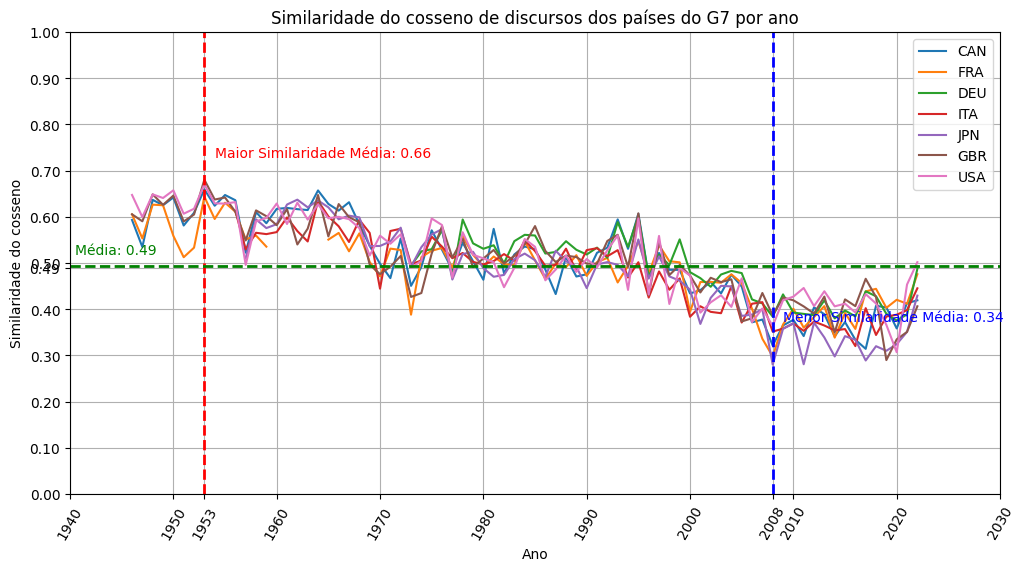

In [14]:
plotar_similaridade_cosseno_ao_longo_dos_anos(G7, "do G7")
# analisar_similaridade_cosseno(G7, "do G7")

#### BRICS

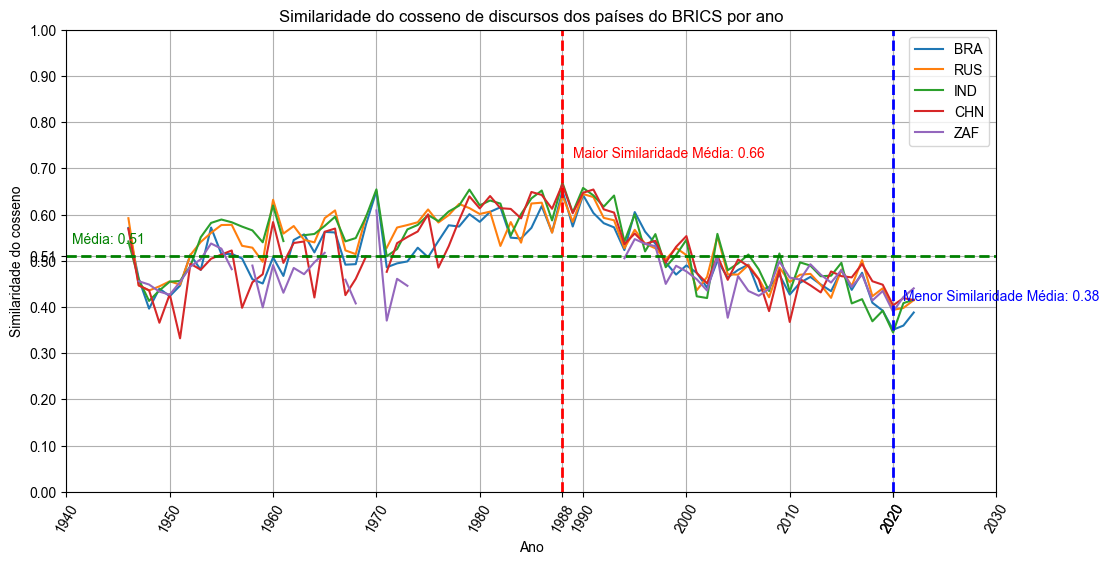

In [76]:
plotar_similaridade_cosseno_ao_longo_dos_anos(BRICS, "do BRICS")

#### BRICS E G7

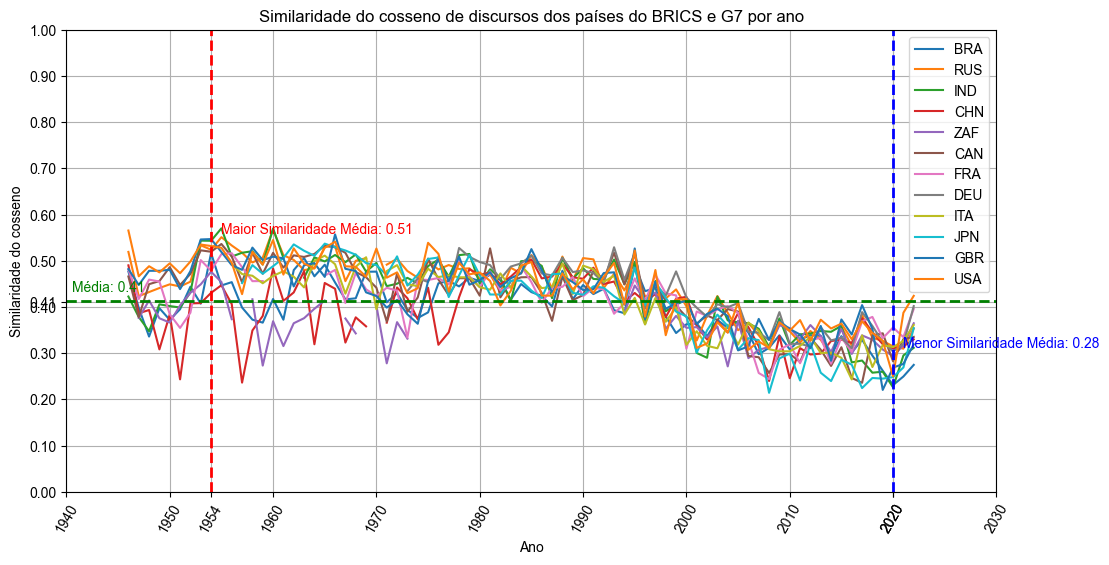

In [77]:
BRICS_G7 = BRICS + G7

plotar_similaridade_cosseno_ao_longo_dos_anos(BRICS_G7, "do BRICS e G7")

#### BRASIL E USA

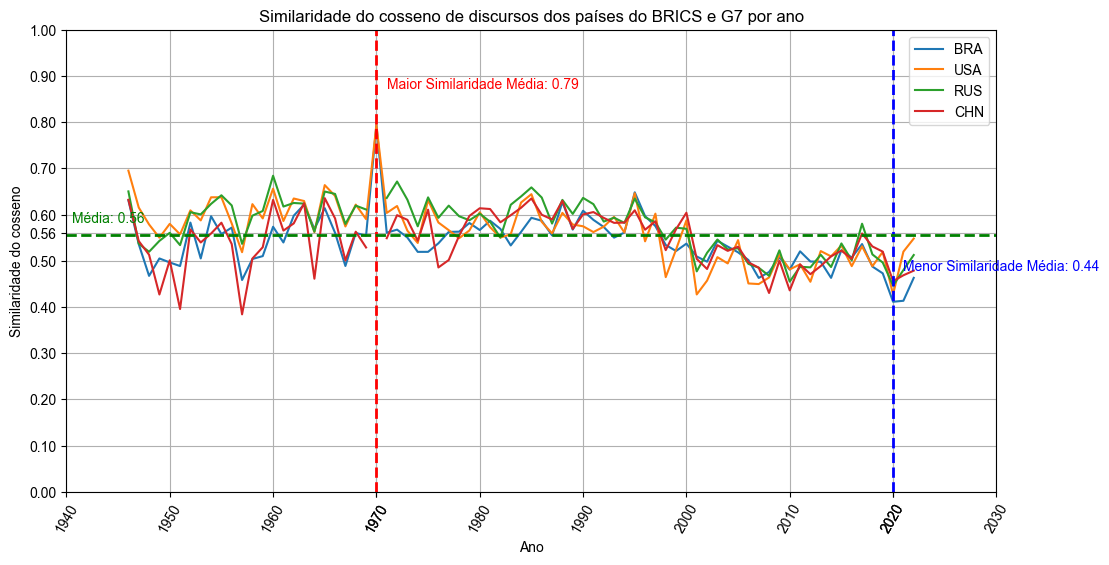

In [81]:
BRA_USA = [
    'BRA',
    'USA',
    'RUS',
    'CHN'
]

plotar_similaridade_cosseno_ao_longo_dos_anos(BRA_USA, "do BRICS e G7")

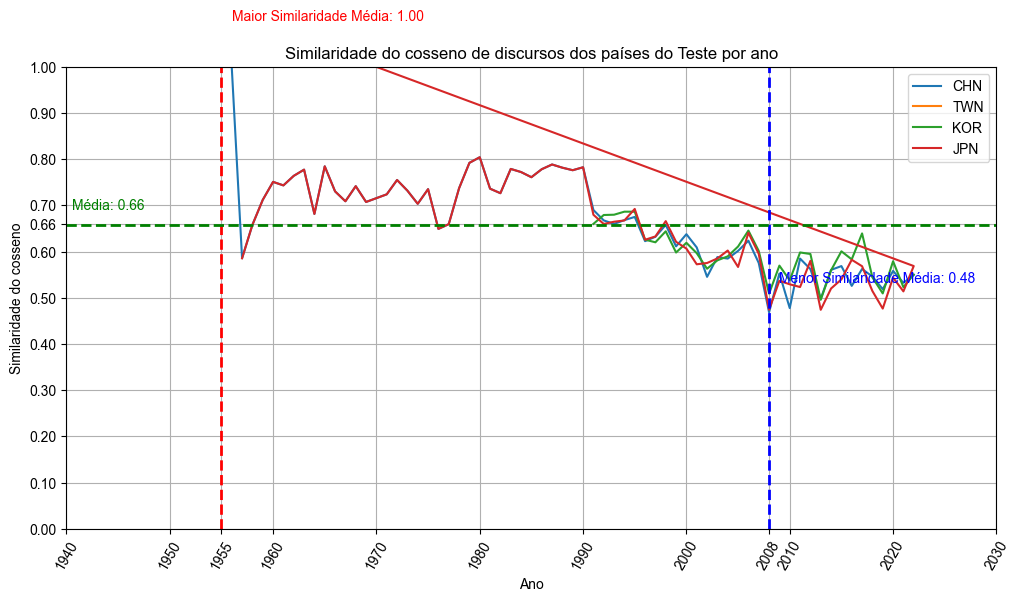

In [80]:
TESTE = ["CHN", "TWN", "KOR", "JPN"]

plotar_similaridade_cosseno_ao_longo_dos_anos(TESTE, "do Teste")

#### TODOS OS PAÍSES

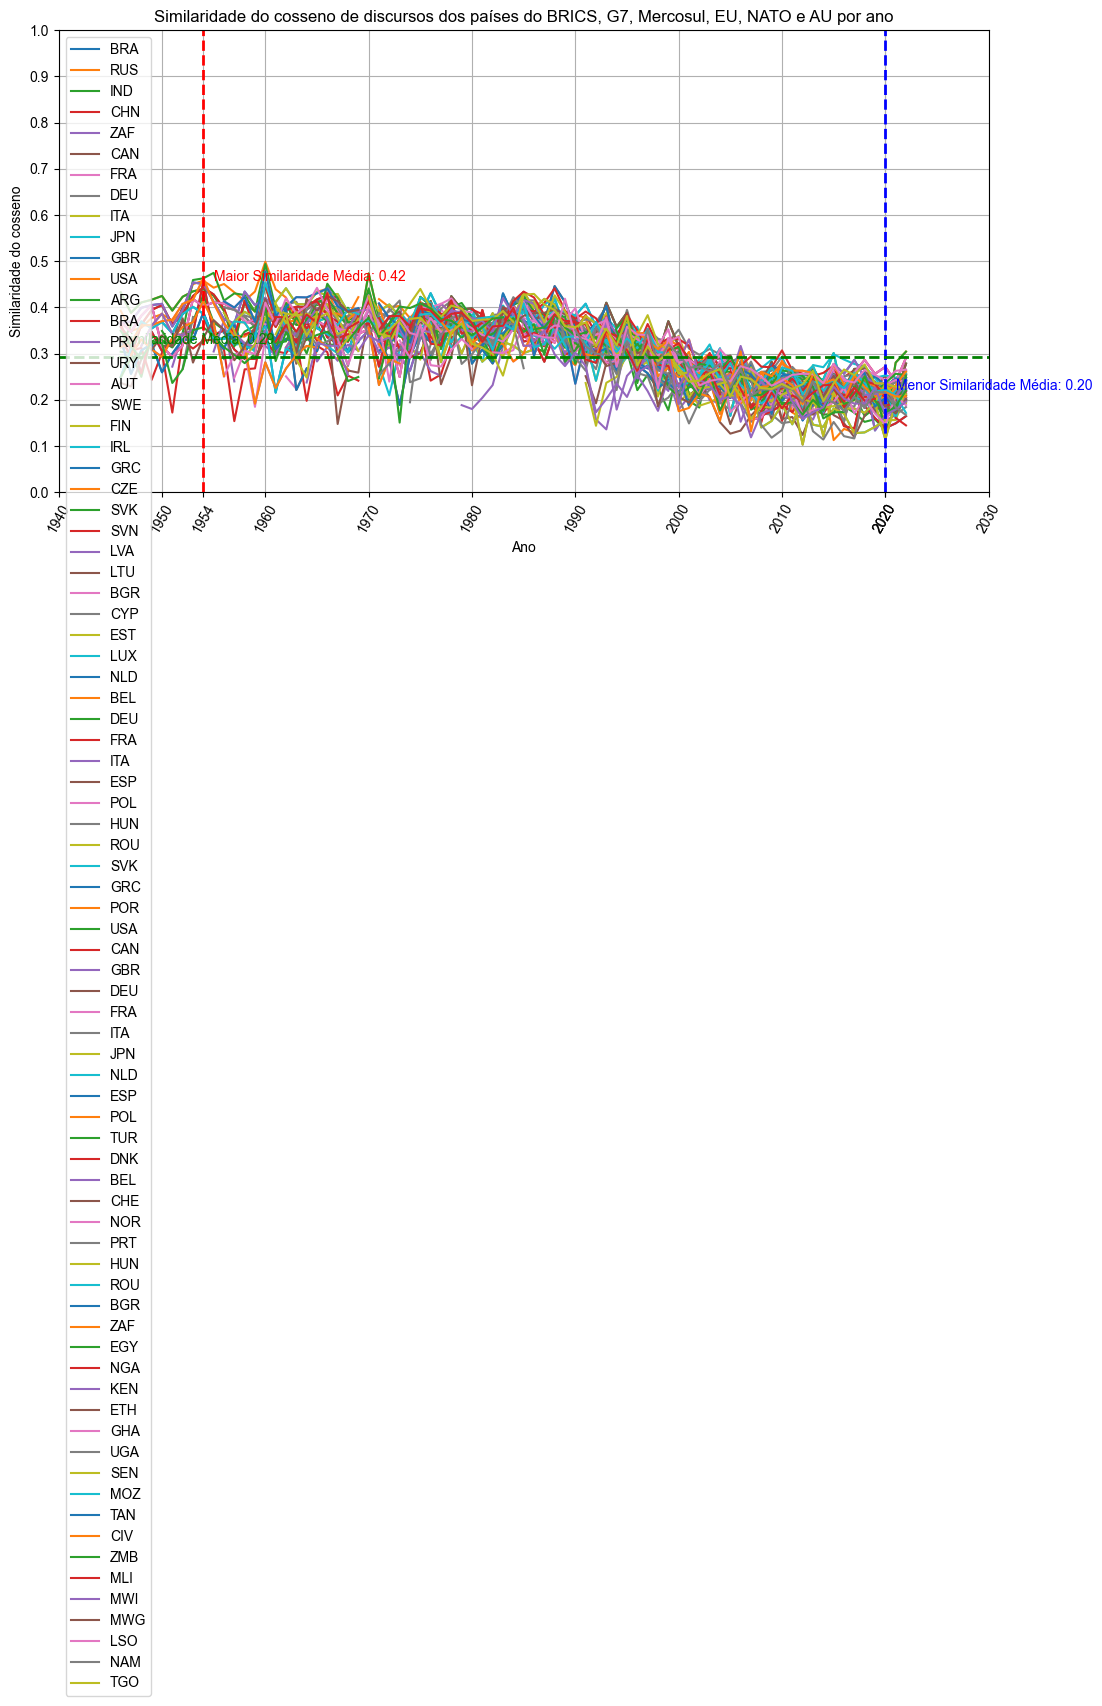

In [58]:
TODOS = BRICS + G7 + MERCOSUL + EU + NATO + AU

plotar_similaridade_cosseno_ao_longo_dos_anos(TODOS, "do BRICS, G7, Mercosul, EU, NATO e AU")